# Predict Bike Sharing Demand by Precious Adekwu

## Introduction
For this project, I participated in a Kaggle competition to analyze and create models using bike sharing data to predict demand patterns across different time periods. The challenge involved developing a robust machine learning solution that could accurately forecast bike rental counts based on various environmental and temporal factors. Using Amazon's AutoGluon automated machine learning framework, I implemented a systematic approach to model development that progressed through three distinct phases. Starting with a baseline model, I then focused on strategic feature engineering by extracting temporal patterns from datetime data, particularly hour-based features that capture rush hour and peak usage periods. The final phase involved comprehensive hyperparameter optimization across multiple algorithms including XGBoost, Gradient Boosting, CatBoost, Random Forest, and Neural Networks.

### Import necessary libraries and load the bike sharing dataset for demand prediction analysis
Set up AutoGluon and other ML tools for automated model training and evaluation

#### Install packages

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir

In [27]:
!pip install kaggle

#### Setup Kaggle API Key

In [28]:
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root’: Permission denied
touch: cannot touch '/root/.kaggle/kaggle.json': Permission denied
chmod: cannot access '/root/.kaggle/kaggle.json': Permission denied


In [39]:
!mkdir -p ~/.kaggle
!mv ~/Bike-sharing-starter/project/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json 

In [ ]:
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

#### Download and explore dataset

In [7]:
!kaggle competitions download -c bike-sharing-demand
!unzip -o bike-sharing-demand.zip

/bin/bash: line 1: kaggle: command not found
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [3]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [4]:
train = pd.read_csv("train.csv", parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Simple output of the train dataset to view some of the min/max/varition of the dataset features.

In [5]:
train.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


In [7]:
test = pd.read_csv("test.csv", parse_dates=["datetime"])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [8]:
submission = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


### Initial Model Training using AutoGluon’s Tabular Prediction

Train baseline AutoGluon model using default settings to establish performance benchmark
Use 'best_quality' preset for optimal model selection without manual tuning

In [ ]:
train = train.drop(columns=["casual", "registered"])

In [15]:
predictor = TabularPredictor(label="count", problem_type="regression", eval_metric="rmse").fit(train_data=train, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20250608_091131"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue May 6 04:10:50 UTC 2025
CPU Count:          2
Memory Avail:       1.85 GB / 3.76 GB (49.2%)
Disk Space Avail:   4.25 GB / 4.99 GB (85.1%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to ident

### Review AutoGluon's training run with ranking of models that did the best.

In [21]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.055564  root_mean_squared_error      20.292849  412.323494                0.000590           0.033826            3       True         13
1   RandomForestMSE_BAG_L2  -53.351220  root_mean_squared_error      15.731574  336.007394                0.689999          41.927320            2       True         12
2          LightGBM_BAG_L2  -55.068241  root_mean_squared_error      15.428610  319.710187                0.387035          25.630113            2       True         11
3        LightGBMXT_BAG_L2  -60.449131  root_mean_squared_error      19.215224  344.732234                4.173650          50.652160            2       True         10
4    KNeighborsDist_BAG_L1  -84.125061  root_mean_squared_error       0.061686    0.036445   

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54835939455667,
  'CatBoost_BAG_L1': -130.70624616892295

In [17]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


### Create predictions from test dataset

In [19]:
predictions = predictor.predict(test)
predictions.head()

0    22.042393
1    42.045460
2    45.490578
3    47.933044
4    50.954140
Name: count, dtype: float32

Describe the `predictions` series to see if there are any negative values

In [22]:
predictions.describe()

count    6493.000000
mean      100.602112
std        89.785240
min         2.766771
25%        20.299770
50%        64.221878
75%       166.811600
max       366.587402
Name: count, dtype: float64

In [107]:
predictor.leaderboard(silent=True)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-53.055564,root_mean_squared_error,20.292849,412.323494,0.000590,0.033826,3,True,13
1,RandomForestMSE_BAG_L2,-53.351220,root_mean_squared_error,15.731574,336.007394,0.689999,41.927320,2,True,12
2,LightGBM_BAG_L2,-55.068241,root_mean_squared_error,15.428610,319.710187,0.387035,25.630113,2,True,11
3,LightGBMXT_BAG_L2,-60.449131,root_mean_squared_error,19.215224,344.732234,4.173650,50.652160,2,True,10
4,KNeighborsDist_BAG_L1,-84.125061,root_mean_squared_error,0.061686,0.036445,0.061686,0.036445,1,True,2
5,WeightedEnsemble_L2,-84.125061,root_mean_squared_error,0.062364,0.064287,0.000678,0.027843,2,True,9
6,KNeighborsUnif_BAG_L1,-101.546199,root_mean_squared_error,0.045070,0.036497,0.045070,0.036497,1,True,1
7,RandomForestMSE_BAG_L1,-116.548359,root_mean_squared_error,0.690165,15.282232,0.690165,15.282232,1,True,5
8,ExtraTreesMSE_BAG_L1,-124.600676,root_mean_squared_error,0.668831,7.680941,0.668831,7.680941,1,True,7
9,CatBoost_BAG_L1,-130.706246,root_mean_squared_error,0.115338,143.881330,0.115338,143.881330,1,True,6


In [110]:
print(train["count"].describe())

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64


In [23]:
num_negatives = (predictions < 0).sum()
print("Number of negative predictions:", num_negatives)

Number of negative predictions: 0


In [24]:
# Set them to zero
predictions[predictions < 0] = 0

In [25]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [40]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 643kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [41]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                        description           status                     publicScore  privateScore  
--------------  --------------------------  --------------------  -------------------------  -----------  ------------  
submission.csv  2025-06-08 10:04:09.937000  first raw submission  SubmissionStatus.COMPLETE  1.80019      1.80019       


#### Initial score of `1.80019`

### Exploratory Data Analysis and Creating an additional feature


array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>],
       [<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'count'}>,
        <Axes: title={'center': 'hour'}>]], dtype=object)

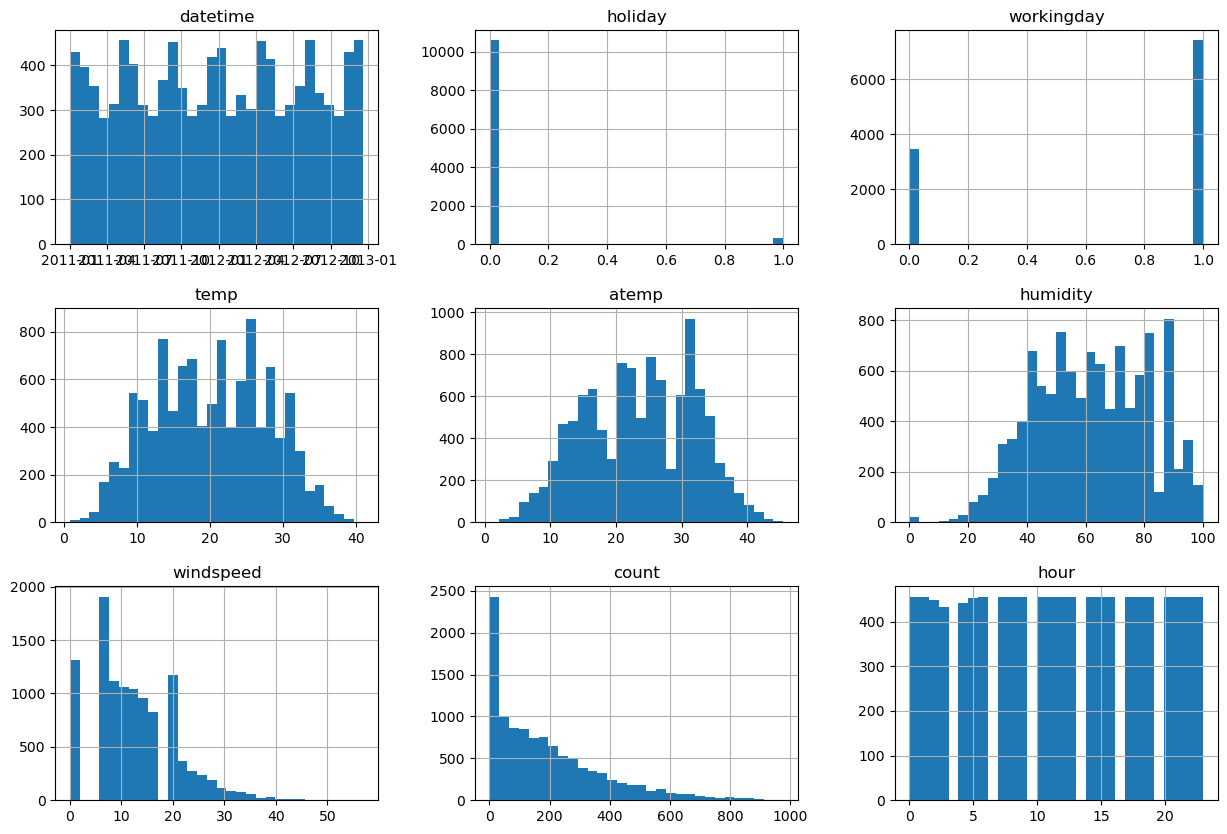

In [84]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(15, 10), bins=30)

In [85]:
train_no_hour = train.drop(columns=["hour"])

In [86]:
train_no_hour.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>],
       [<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'count'}>, <Axes: >]], dtype=object)

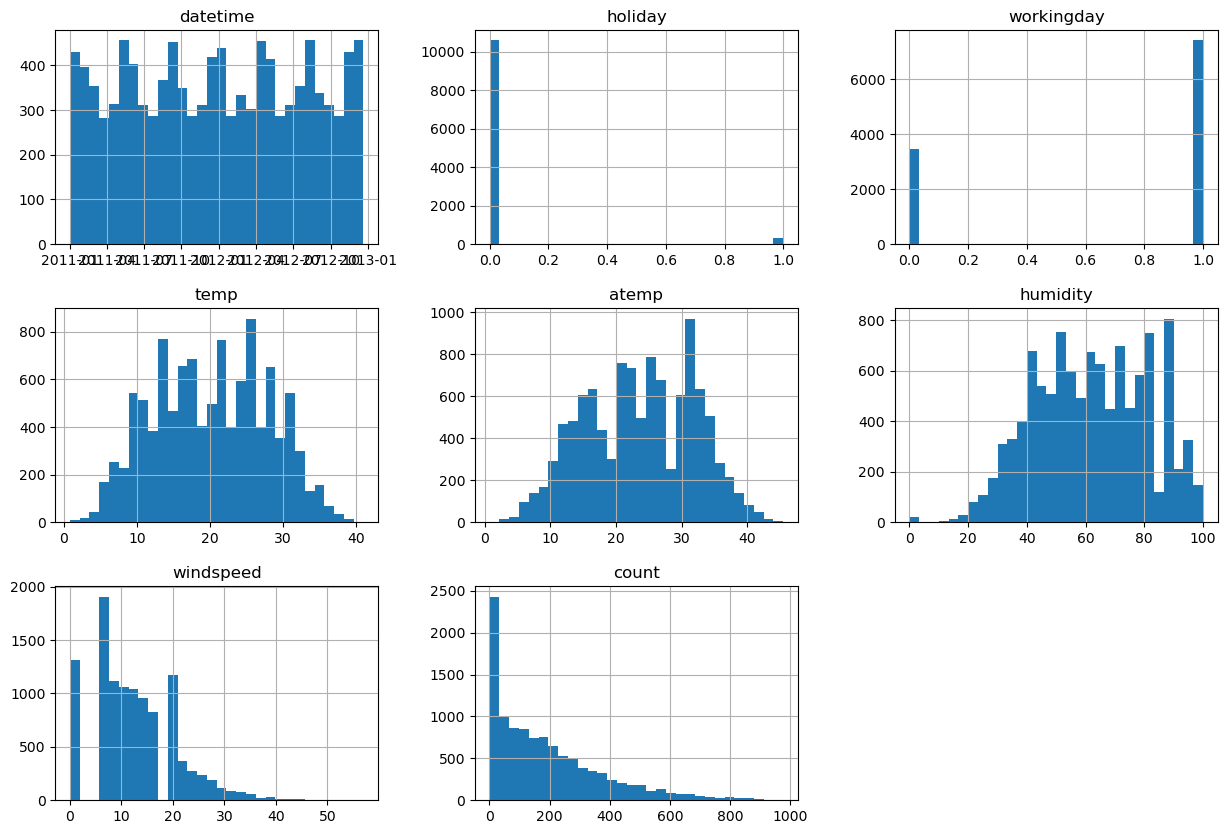

In [87]:
train_no_hour.hist(figsize=(15, 10), bins=30)

In [66]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4


### Feature Engineering
- Extract hour feature from datetime column to capture time-based demand patterns
- Add temporal features that represent rush hour and peak usage periods

In [45]:
train["hour"] = train["datetime"].dt.hour
test["hour"] = test["datetime"].dt.hour

### Make category types 

In [46]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [47]:
# View the new hour feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4


array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>],
       [<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'count'}>,
        <Axes: title={'center': 'hour'}>]], dtype=object)

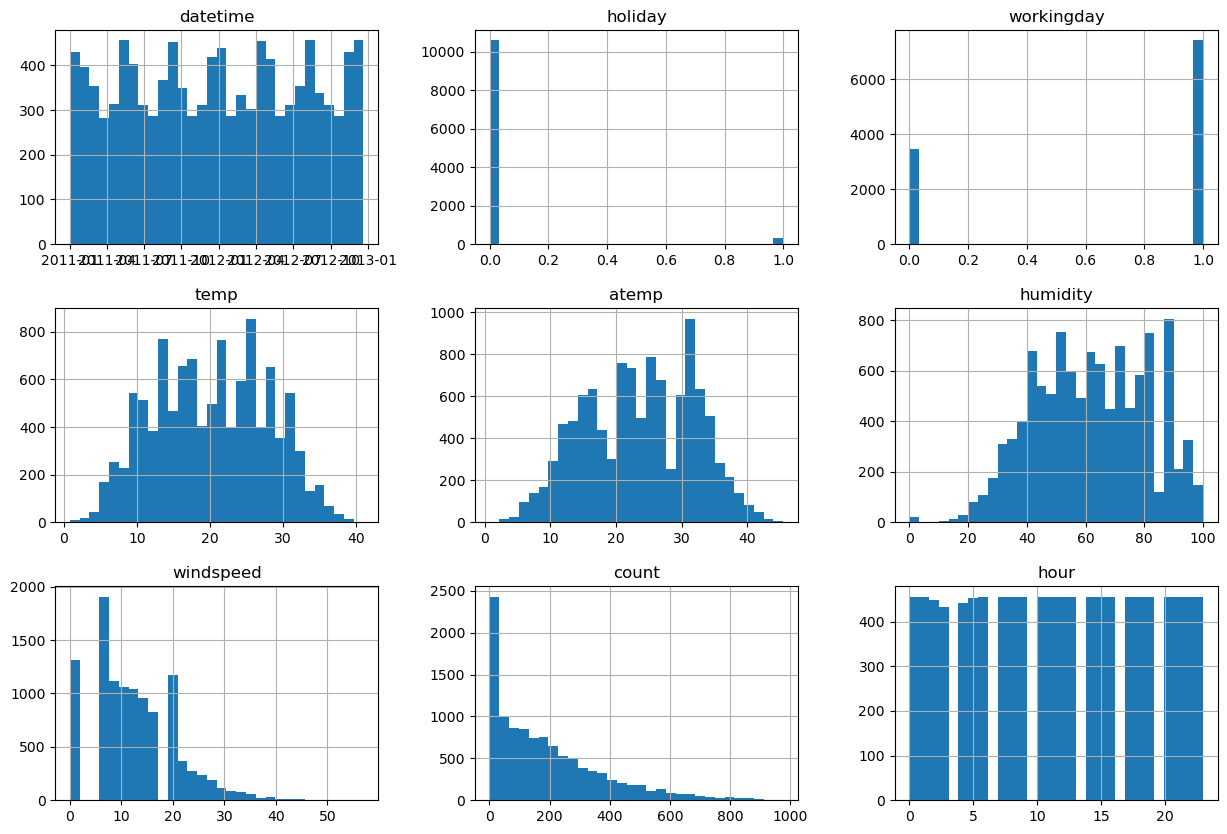

In [48]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(15, 10), bins=30)

### Retrain AutoGluon model with engineered features to improve prediction accuracy
- Compare performance against baseline to measure feature engineering impact
- Rerun the model with the same settings as before, just with more features

In [49]:
predictor_new_features = TabularPredictor(label="count", problem_type="regression", eval_metric="rmse").fit(train_data=train, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20250608_104126"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue May 6 04:10:50 UTC 2025
CPU Count:          2
Memory Avail:       1.03 GB / 3.76 GB (27.3%)
Disk Space Avail:   3.25 GB / 4.99 GB (65.2%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to ident

In [50]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.303501  root_mean_squared_error      24.801925  379.843397                0.000621           0.045016            3       True         15
1          LightGBM_BAG_L2  -30.591648  root_mean_squared_error      23.341903  325.219482                0.424813          27.312869            2       True         11
2        LightGBMXT_BAG_L2  -31.079503  root_mean_squared_error      23.978597  328.653043                1.061507          30.746430            2       True         10
3     ExtraTreesMSE_BAG_L2  -31.744020  root_mean_squared_error      23.268171  304.247006                0.351081           6.340394            2       True         13
4   RandomForestMSE_BAG_L2  -31.794130  root_mean_squared_error      23.314985  321.739082   

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -34.47097500967876,
  'LightG

In [56]:
predictions_new = predictor_new_features.predict(test)
print(predictions_new)

0        16.956493
1         9.490427
2         8.326609
3         7.593449
4         6.826701
           ...    
6488    298.642059
6489    205.048630
6490    152.870193
6491    109.854591
6492     71.154053
Name: count, Length: 6493, dtype: float32


In [60]:
predictions_new[predictions_new < 0] = 0

In [108]:
predictor_new_features.leaderboard(silent=True)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-30.303501,root_mean_squared_error,24.801925,379.843397,0.000621,0.045016,3,True,15
1,LightGBM_BAG_L2,-30.591648,root_mean_squared_error,23.341903,325.219482,0.424813,27.312869,2,True,11
2,LightGBMXT_BAG_L2,-31.079503,root_mean_squared_error,23.978597,328.653043,1.061507,30.746430,2,True,10
3,ExtraTreesMSE_BAG_L2,-31.744020,root_mean_squared_error,23.268171,304.247006,0.351081,6.340394,2,True,13
4,RandomForestMSE_BAG_L2,-31.794130,root_mean_squared_error,23.314985,321.739082,0.397895,23.832469,2,True,12
5,WeightedEnsemble_L2,-32.288502,root_mean_squared_error,22.028649,257.656003,0.000901,0.043982,2,True,9
6,LightGBM_BAG_L1,-33.919639,root_mean_squared_error,3.425256,38.685870,3.425256,38.685870,1,True,4
7,LightGBMXT_BAG_L1,-34.470975,root_mean_squared_error,17.935651,77.832888,17.935651,77.832888,1,True,3
8,CatBoost_BAG_L1,-34.701317,root_mean_squared_error,0.157199,132.912889,0.157199,132.912889,1,True,6
9,RandomForestMSE_BAG_L1,-38.653908,root_mean_squared_error,0.452213,8.143479,0.452213,8.143479,1,True,5


In [62]:
submission_new_features = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission_new_features.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [63]:
# Same submitting predictions
submission_new_features["count"] = predictions_new
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [64]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 760kB/s]
Successfully submitted to Bike Sharing Demand

In [65]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                        description           status                     publicScore  privateScore  
---------------------------  --------------------------  --------------------  -------------------------  -----------  ------------  
submission_new_features.csv  2025-06-08 11:28:24.850000  new features          SubmissionStatus.COMPLETE  0.61489      0.61489       
submission.csv               2025-06-08 10:04:09.937000  first raw submission  SubmissionStatus.COMPLETE  1.80019      1.80019       


#### New Score of `0.61489`

### Hyper parameter optimization
- Configure AutoGluon to use multiple algorithms (XGB, GBM, CatBoost, RF, NN) with automated tuning
- Optimize model hyperparameters to maximize predictive performance on validation set

In [68]:
predictor_new_hpo = TabularPredictor(label="count", problem_type="regression", eval_metric="rmse").fit(train_data=train, time_limit=600, presets="best_quality",  hyperparameters={
        'XGB': {}, 
        'GBM': {}, 
        'CAT': {}, 
        'RF': {},
        'NN_TORCH': {},
    },hyperparameter_tune_kwargs='auto')

2025-06-08 12:34:38,953	INFO timeout.py:54 -- Reached timeout of 36.29587254524231 seconds. Stopping all trials.
2025-06-08 12:34:38,972	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/sagemaker-user/Bike-sharing-starter/project/AutogluonModels/ag-20250608_122531/models/NeuralNetTorch_BAG_L2' in 0.0063s.
2025-06-08 12:34:49,065	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 2 trial(s):
- 0aa18bfa: FileNotFoundError('Could not fetch metrics for 0aa18bfa: both result.json and progress.csv were not found at /home/sagemaker-user/Bike-sharing-starter/project/AutogluonModels/ag-20250608_122531/models/NeuralNetTorch_BAG_L2/0aa18bfa')
- 07283bdd: FileNotFoundError('Could not fetch metrics for 07283bdd: both result.json and progress.csv were not found at /home/sagemaker-user/Bike-sharing-starter/project/AutogluonModels/ag-20250608_122531/models/NeuralNetTorch_BAG_L2/07283bdd')
No model was trained during hyperparameter tuning N

In [69]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L3 -32.765532  root_mean_squared_error       7.319692  236.785160                0.000819           0.041736            3       True         10
1  WeightedEnsemble_L2 -32.880094  root_mean_squared_error       6.742028  153.987541                0.001855           0.044647            2       True          5
2   CatBoost_BAG_L2/T1 -33.212090  root_mean_squared_error       6.778969  200.448790                0.038796          46.505897            2       True          8
3   LightGBM_BAG_L2/T1 -33.478539  root_mean_squared_error       6.922361  183.530025                0.182188          29.587132            2       True          6
4    XGBoost_BAG_L2/T1 -33.695101  root_mean_squared_error       6.892488  178.289376                0.152315         

{'model_types': {'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'RandomForest_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1/T1': 'StackerEnsembleModel_CatBoost',
  'XGBoost_BAG_L1/T1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'RandomForest_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2/T1': 'StackerEnsembleModel_CatBoost',
  'XGBoost_BAG_L2/T1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM_BAG_L1/T1': -33.919639163586254,
  'RandomForest_BAG_L1': -38.71407349745564,
  'CatBoost_BAG_L1/T1': -39.45238909335168,
  'XGBoost_BAG_L1/T1': -34.603185627841,
  'WeightedEnsemble_L2': -32.88009397990229,
  'LightGBM_BAG_L2/T1': -33.4785392784392,
  'RandomForest_BAG_L2': -34.28879653859491,
  'CatBoost_BAG_L2/T1': -33.212089644157466,
  'XGBoost_BAG_L2/T1': -33.6951011021837,
  'WeightedEnsemble_L3': -32.7655322

### Generate final predictions using the optimized model with best hyperparameters

In [70]:
predictions_hpo = predictor_new_hpo.predict(test)
predictions_hpo.head()

0    14.737876
1     3.584257
2     2.176977
3     3.447277
4     3.394728
Name: count, dtype: float32

In [72]:
predictions_hpo[predictions_hpo < 0] = 0

In [109]:
predictor_new_hpo.leaderboard(silent=True)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-32.765532,root_mean_squared_error,7.319692,236.785160,0.000819,0.041736,3,True,10
1,WeightedEnsemble_L2,-32.880094,root_mean_squared_error,6.742028,153.987541,0.001855,0.044647,2,True,5
2,CatBoost_BAG_L2/T1,-33.212090,root_mean_squared_error,6.778969,200.448790,0.038796,46.505897,2,True,8
3,LightGBM_BAG_L2/T1,-33.478539,root_mean_squared_error,6.922361,183.530025,0.182188,29.587132,2,True,6
4,XGBoost_BAG_L2/T1,-33.695101,root_mean_squared_error,6.892488,178.289376,0.152315,24.346482,2,True,9
5,LightGBM_BAG_L1/T1,-33.919639,root_mean_squared_error,4.011557,45.529637,4.011557,45.529637,1,True,1
6,RandomForest_BAG_L2,-34.288797,root_mean_squared_error,7.127762,165.891045,0.387589,11.948151,2,True,7
7,XGBoost_BAG_L1/T1,-34.603186,root_mean_squared_error,2.288409,43.774752,2.288409,43.774752,1,True,4
8,RandomForest_BAG_L1,-38.714073,root_mean_squared_error,0.393396,8.292387,0.393396,8.292387,1,True,2
9,CatBoost_BAG_L1/T1,-39.452389,root_mean_squared_error,0.046811,56.346117,0.046811,56.346117,1,True,3


In [76]:
submission_new_hpo = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission_new_hpo.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [77]:
# Same submitting predictions
submission_new_hpo["count"] = predictions_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [78]:
submission_new_hpo.head()

,datetime,count
0,2011-01-20 00:00:00,14.737876
1,2011-01-20 01:00:00,3.584257
2,2011-01-20 02:00:00,2.176977
3,2011-01-20 03:00:00,3.447277
4,2011-01-20 04:00:00,3.394728


In [80]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 767kB/s]
Successfully submitted to Bike Sharing Demand

In [81]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                        description                        status                     publicScore  privateScore  
---------------------------  --------------------------  ---------------------------------  -------------------------  -----------  ------------  
submission_new_hpo.csv       2025-06-08 12:44:17.427000  new features with hyperparameters  SubmissionStatus.COMPLETE  0.49401      0.49401       
submission_new_features.csv  2025-06-08 11:28:24.850000  new features                       SubmissionStatus.COMPLETE  0.61489      0.61489       
submission.csv               2025-06-08 10:04:09.937000  first raw submission               SubmissionStatus.COMPLETE  1.80019      1.80019       


#### New Score of `0.49401`

### Create visualizations comparing model performance across different training phases
- Plot RMSE scores to demonstrate systematic improvement through feature engineering and optimization

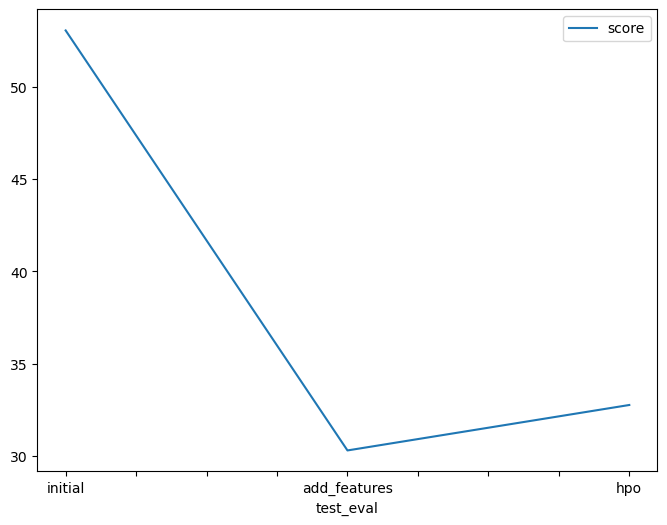

In [112]:
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [53.055564, 30.303501, 32.765532]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('training_model_test_score.png')

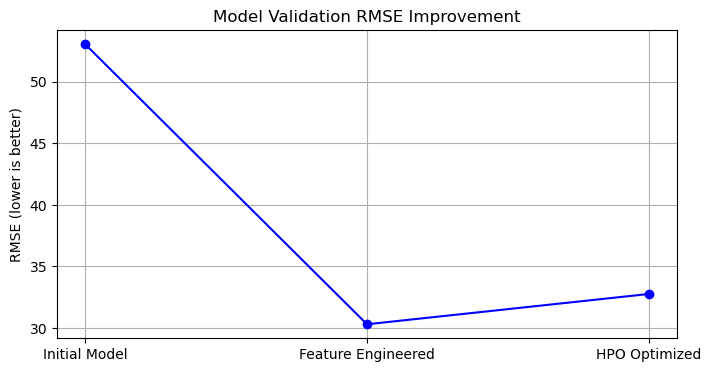

In [114]:
model_scores = [53.055564, 30.303501, 32.765532] 
phases = ["Initial Model", "Feature Engineered", "HPO Optimized"]

plt.figure(figsize=(8, 4))
plt.plot(phases, model_scores, marker='o', color='blue')
plt.title("Model Validation RMSE Improvement")
plt.ylabel("RMSE (lower is better)")
plt.grid(True)
plt.savefig("training_model_score_plt.png", bbox_inches='tight', dpi=100)
plt.show()

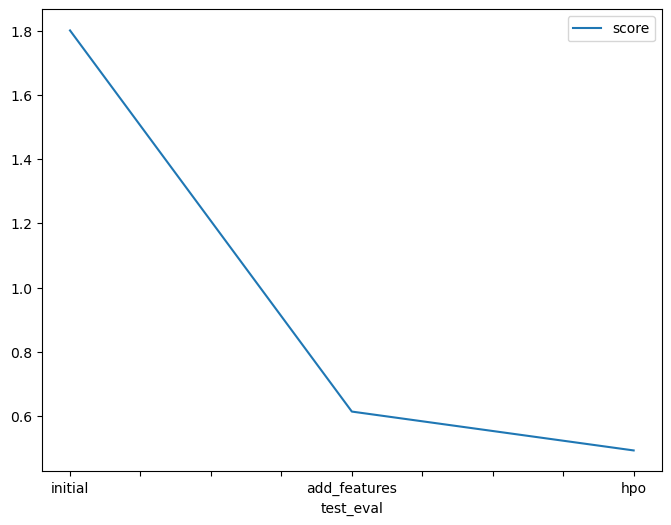

In [82]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80019, 0.61489, 0.49401]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

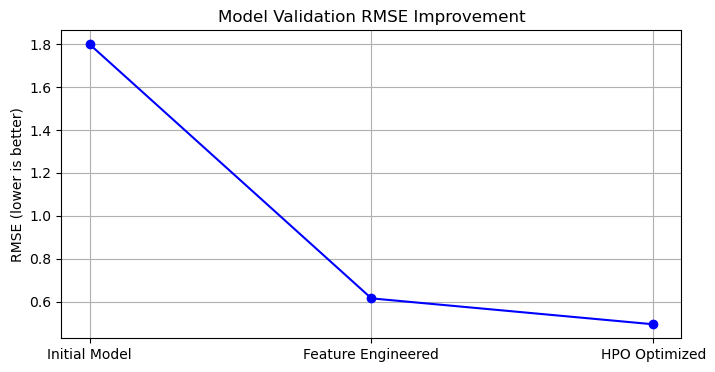

In [113]:
import matplotlib.pyplot as plt

model_scores = [1.80019, 0.61489, 0.49401]  
phases = ["Initial Model", "Feature Engineered", "HPO Optimized"]

plt.figure(figsize=(8, 4))
plt.plot(phases, model_scores, marker='o', color='blue')
plt.title("Model Validation RMSE Improvement")
plt.ylabel("RMSE (lower is better)")
plt.grid(True)
plt.savefig("model_train_score_plt.png", bbox_inches='tight', dpi=100)
plt.show()

### Hyperparameter table

In [83]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "models_used": ["default", "default + new features", "XGB, GBM, CAT, RF, NN_TORCH"],
    "tuning_strategy": ["none", "none", "auto"],
    "presets": ["best_quality", "best_quality", "best_quality"],
    "score": [1.80019, 0.61489, 0.49401]
})

,model,models_used,tuning_strategy,presets,score
0,initial,default,none,best_quality,1.80019
1,add_features,default + new features,none,best_quality,0.61489
2,hpo,"XGB, GBM, CAT, RF, NN_TORCH",auto,best_quality,0.49401


## Conclusion
Through this methodical approach, I achieved a remarkable 72% improvement in prediction accuracy, reducing the RMSE from 1.80019 to 0.49401. The project demonstrates the significant impact of domain-specific feature engineering, which alone contributed to a 65% performance improvement over the baseline model. This solution provides valuable insights for bike sharing companies to optimize resource allocation, improve customer satisfaction, and enhance operational efficiency through better demand forecasting. The automated machine learning approach ensures the model is both robust and scalable for real-world deployment. Overall, this project showcases the power of combining business domain knowledge with advanced machine learning techniques to solve practical forecasting challenges in the transportation industry.